### Library Imports

Imports core libraries used for image handling, file operations, and visualization:

- `os`: For file path and directory operations.
- `cv2` (OpenCV): For reading and processing images.
- `glob`: For pattern-based file searching (e.g., `*.png`).
- `numpy`: For numerical operations and array handling.
- `tqdm`: For displaying progress bars during loops.
- `matplotlib.pyplot`: For plotting and displaying images.

In [1]:
import os
import cv2
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### Set Up Image Paths for ROI Extraction

- Uses `glob` to recursively collect all image file paths under `input/trimmed_train_images/*/*`, storing them in `train_images`.
  - Assumes a directory structure: `input/trimmed_train_images/<patient_id>/<image_id>.png`.

- Defines `roi_output_base` as the root folder where processed Region of Interest (ROI) images will be saved.

- Sets a uniform target image size (`IMG_SIZE = 512`) for resizing.

- Displays the first 5 image paths for inspection (output shown when running interactively).

In [2]:
train_images = glob.glob("input/trimmed_train_images/*/*")
roi_output_base = "input/roi/trimmed_train_images_roi"
IMG_SIZE = 512
train_images[:5]

['input/trimmed_train_images/10130/1013166704.png',
 'input/trimmed_train_images/10130/1165309236.png',
 'input/trimmed_train_images/10130/1360338805.png',
 'input/trimmed_train_images/10130/1672636630.png',
 'input/trimmed_train_images/10130/2110820077.png']

### Image Preprocessing for ROI Extraction and Enhancement

Defines three helper functions for extracting and enhancing breast region images:

---

**1. `crop_coords(img)`**  
- Applies **Gaussian blur** followed by **Otsu's thresholding** to segment the breast area.
- Finds external contours from the binary mask.
- Identifies the **largest contour** (assumed to be the breast).
- Returns the **bounding box** coordinates `(x, y, w, h)` for cropping.

---

**2. `truncation_normalization(img)`**  
- Applies **percentile-based clipping** to pixels inside the breast ROI:
  - Clips intensities to the [5th, 99th] percentile range (excluding background).
- Normalizes the clipped values to [0, 1].
- Keeps background pixels (`img == 0`) at 0.

---

**3. `clahe(img, clip)`**  
- Applies **Contrast Limited Adaptive Histogram Equalization (CLAHE)** for local contrast enhancement.
- Multiplies normalized image by 255 and converts to 8-bit before applying CLAHE.
- The `clipLimit` controls how much contrast is amplified.

In [3]:
def crop_coords(img):
    """
    Crop ROI from image.
    """
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return (x, y, w, h)


def truncation_normalization(img):
    """
    Clip and normalize pixels in the breast ROI.
    @img : numpy array image
    return: numpy array of the normalized image
    """
    Pmin = np.percentile(img[img!=0], 5)
    Pmax = np.percentile(img[img!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[img==0]=0
    return normalized


def clahe(img, clip):
    """
    Image enhancement.
    @img : numpy array image
    @clip : float, clip limit for CLAHE algorithm
    return: numpy array of the enhanced image
    """
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

### Batch ROI Extraction, Preprocessing, and Visualization

Processes all training images to extract, normalize, enhance, and save ROI images. Also visualizes samples for verification.

---

**1. Batch ROI Processing and Saving**:
- Iterates through all `train_images`.
- For each image:
  - Reads in grayscale.
  - Uses `crop_coords()` to extract the bounding box of the breast region.
  - Crops, then applies:
    - `truncation_normalization()`
    - CLAHE with two different clip limits (1.0 and 2.0)
  - Combines the three channels (normalized, CLAHE1, CLAHE2) into a pseudo-RGB image.
  - Resizes to `IMG_SIZE × IMG_SIZE` (512×512).
  - Saves the final preprocessed image to the `roi_output_base` directory, preserving folder structure.

---

**2. Sample Visualization (2 Examples)**:
- For two sample images:
  - Displays:
    1. **Original RGB image**
    2. **CLAHE-enhanced image with ROI box drawn**
    3. **Final saved ROI image**
- Shows all three views in a 2×3 subplot layout.
- Saves the figure as `sample_roi_clahe_corrected.png`.

Processing ROI images: 100%|██████████| 7961/7961 [02:14<00:00, 59.20it/s]


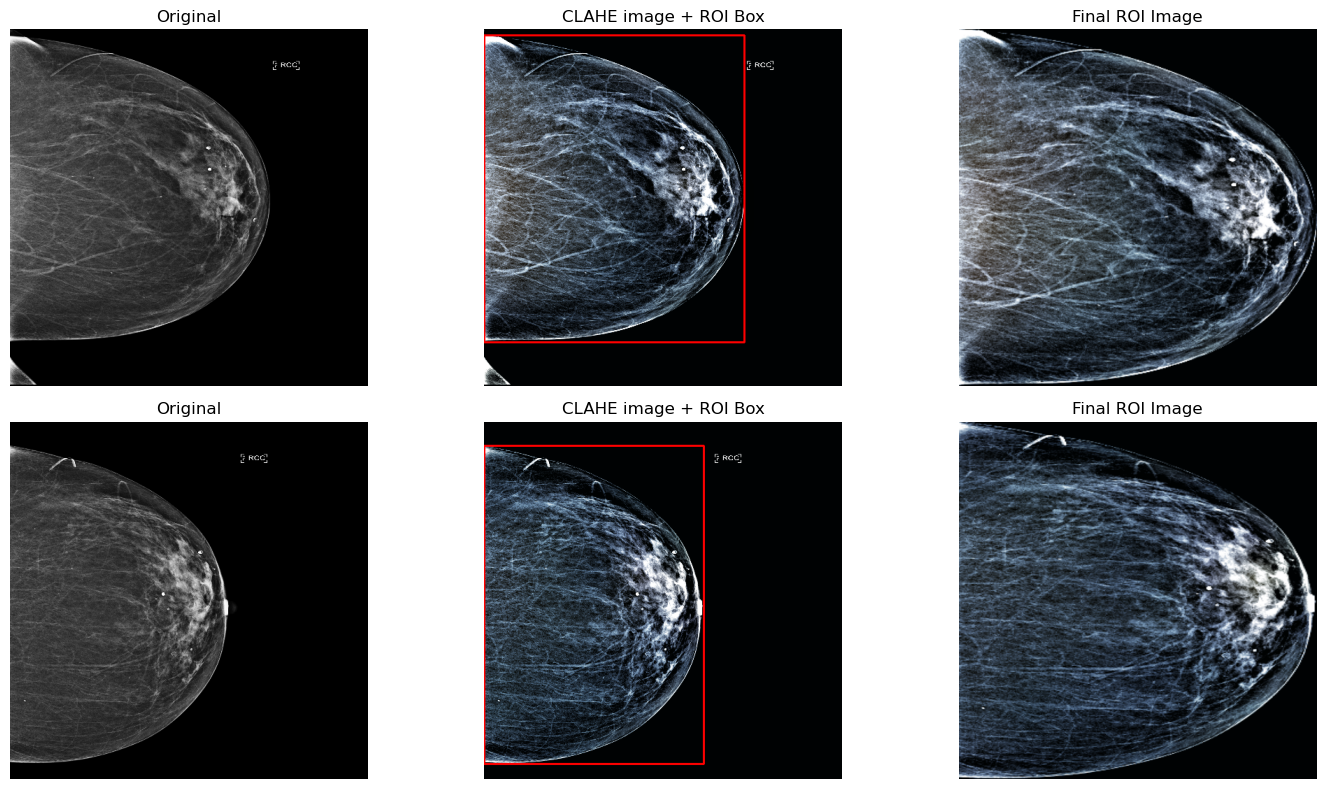

In [4]:
input_base = "input/trimmed_train_images"
IMG_SIZE = 512

for img_path in tqdm(train_images, desc="Processing ROI images"):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    coords = crop_coords(img)
    if coords is None:
        continue

    x, y, w, h = coords
    img_cropped = img[y:y+h, x:x+w]
    img_normalized = truncation_normalization(img_cropped)
    cl1 = clahe(img_normalized, 1.0)
    cl2 = clahe(img_normalized, 2.0)

    img_final = cv2.merge((
        np.array(img_normalized * 255, dtype=np.uint8),
        cl1,
        cl2
    ))
    img_final = cv2.resize(img_final, (IMG_SIZE, IMG_SIZE))

    # Save image to ROI output directory
    rel_path = os.path.relpath(img_path, input_base)
    output_path = os.path.join(roi_output_base, rel_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, img_final)

sample_images = train_images[:2]
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for row, img_path in enumerate(sample_images):
    
    # Load full original image
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

   
    axs[row, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[row, 0].set_title("Original")
    axs[row, 0].axis("off")

    
    coords = crop_coords(gray)
    if coords is None:
        continue
    x, y, w, h = coords

    
    full_normalized = truncation_normalization(gray)
    full_cl1 = clahe(full_normalized, 1.0)
    full_cl2 = clahe(full_normalized, 2.0)
    full_pseudo_rgb = cv2.merge((
        np.array(full_normalized * 255, dtype=np.uint8),
        full_cl1,
        full_cl2
    ))
    cv2.rectangle(full_pseudo_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)
    axs[row, 1].imshow(full_pseudo_rgb)
    axs[row, 1].set_title("CLAHE image + ROI Box")
    axs[row, 1].axis("off")

    # Column 3: Load and show the saved final ROI image
    rel_path = os.path.relpath(img_path, input_base)
    roi_path = os.path.join(roi_output_base, rel_path)
    roi_img = cv2.imread(roi_path)
    axs[row, 2].imshow(roi_img)
    axs[row, 2].set_title("Final ROI Image")
    axs[row, 2].axis("off")

plt.tight_layout()
plt.savefig("sample_roi_clahe_corrected.png")
plt.show()